In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers


training_dir = './spectrograms/train'
validation_dir = './spectrograms/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    horizontal_flip = True
)



train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'
)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])


model.compile(
    optimizer=Adam(lr=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('pt16-m55013.h5', save_best_only=True)


history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)


model = load_model('pt16-m55013.h5')


def get_predictions_and_labels(model, directory, image_size=(256, 256), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=False
    )

    true_labels = generator.classes
    file_paths = generator.filepaths
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    results = [(file_paths[i], true_labels[i], predicted_classes[i]) for i in range(len(file_paths))]

    return results

train_results = get_predictions_and_labels(model, training_dir)

Found 2774 images belonging to 8 classes.
Found 648 images belonging to 8 classes.


Epoch 1/20
87/87 [==============================] - ETA: 0s - loss: 1.8491 - accuracy: 0.2523

C:\Users\Alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 54s 618ms/step - loss: 1.8491 - accuracy: 0.2523 - val_loss: 1.4629 - val_accuracy: 0.3519
Epoch 2/20
87/87 [==============================] - 50s 573ms/step - loss: 1.3547 - accuracy: 0.4095 - val_loss: 0.8157 - val_accuracy: 0.5910
Epoch 3/20
87/87 [==============================] - 50s 577ms/step - loss: 0.8793 - accuracy: 0.5649 - val_loss: 0.6324 - val_accuracy: 0.6713
Epoch 4/20
87/87 [==============================] - 50s 576ms/step - loss: 0.7238 - accuracy: 0.6377 - val_loss: 0.5568 - val_accuracy: 0.6590
Epoch 5/20
87/87 [==============================] - 51s 581ms/step - loss: 0.6429 - accuracy: 0.6748 - val_loss: 0.4292 - val_accuracy: 0.8179
Epoch 6/20
87/87 [==============================] - 50s 573ms/step - loss: 0.5733 - accuracy: 0.7311 - val_loss: 0.3082 - val_accuracy: 0.9275
Epoch 7/20
87/87 [==============================] - 50s 572ms/step - loss: 0.4739 - accuracy: 0.7898 - val_loss: 0.1926 - val_accuracy: 0.9398
Epoch 8/20

In [3]:
from tensorflow.keras.models import Sequential, load_model
model = load_model('pt16-m55013.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

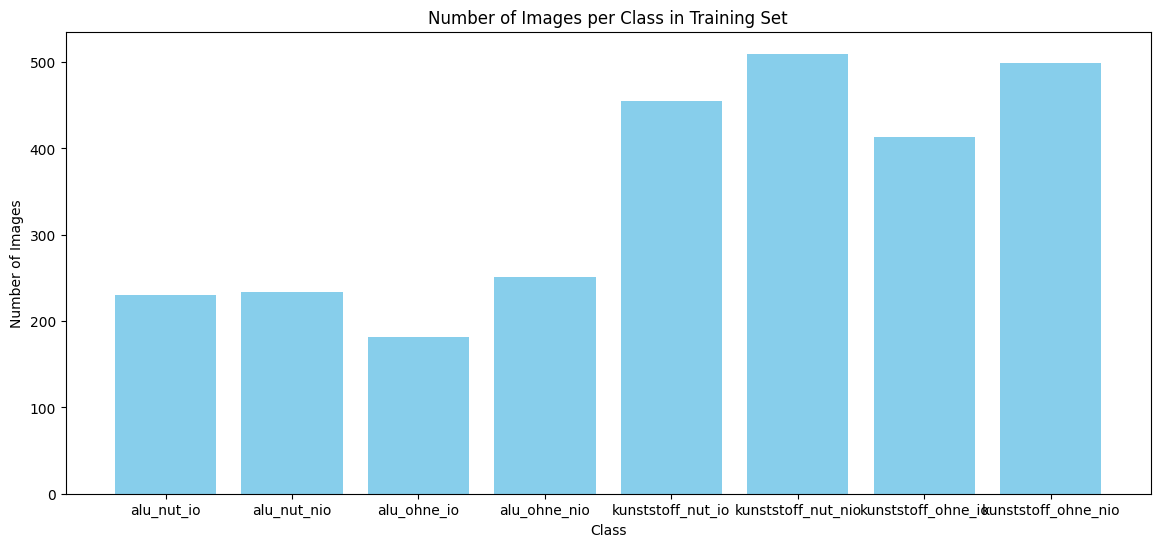

In [4]:
import matplotlib.pyplot as plt
labels_count = np.bincount(train_generator.classes)
class_labels = list(train_generator.class_indices.keys())


plt.figure(figsize=(14, 6))
plt.bar(class_labels, labels_count, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.show()

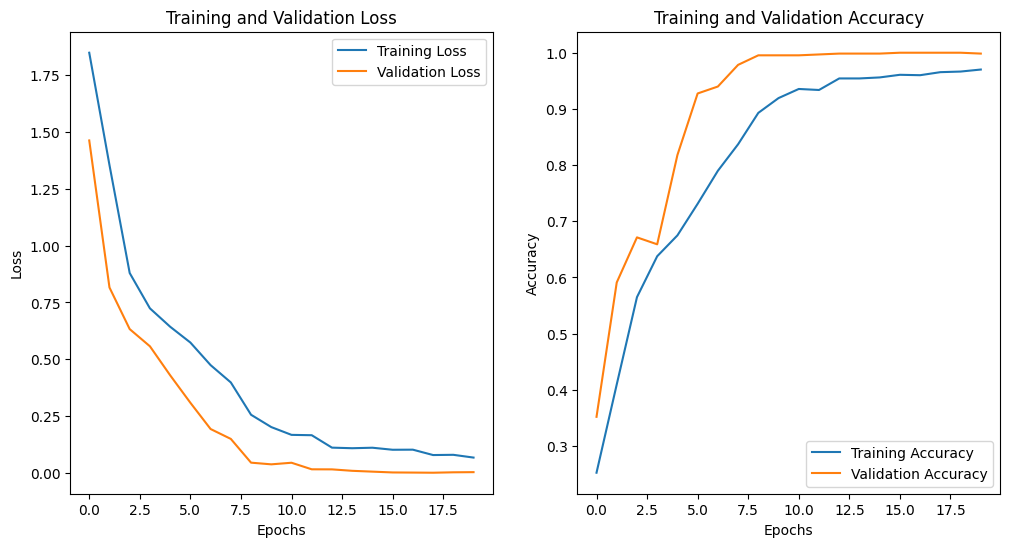

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Found 648 images belonging to 8 classes.
Found 571 images belonging to 8 classes.
21/21 [==============================] - 6s 263ms/step


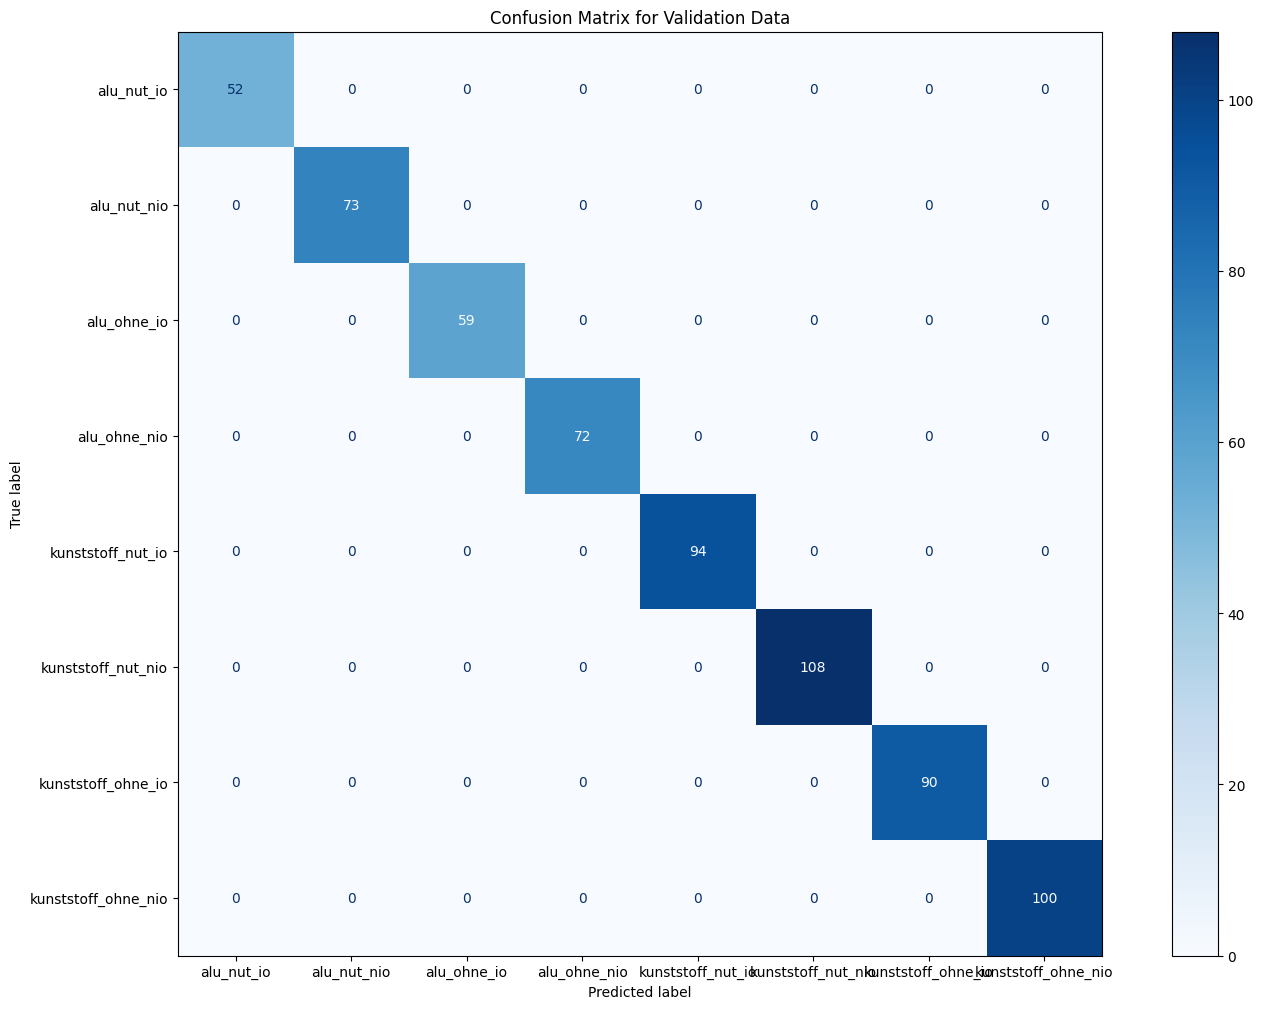

18/18 [==============================] - 6s 322ms/step


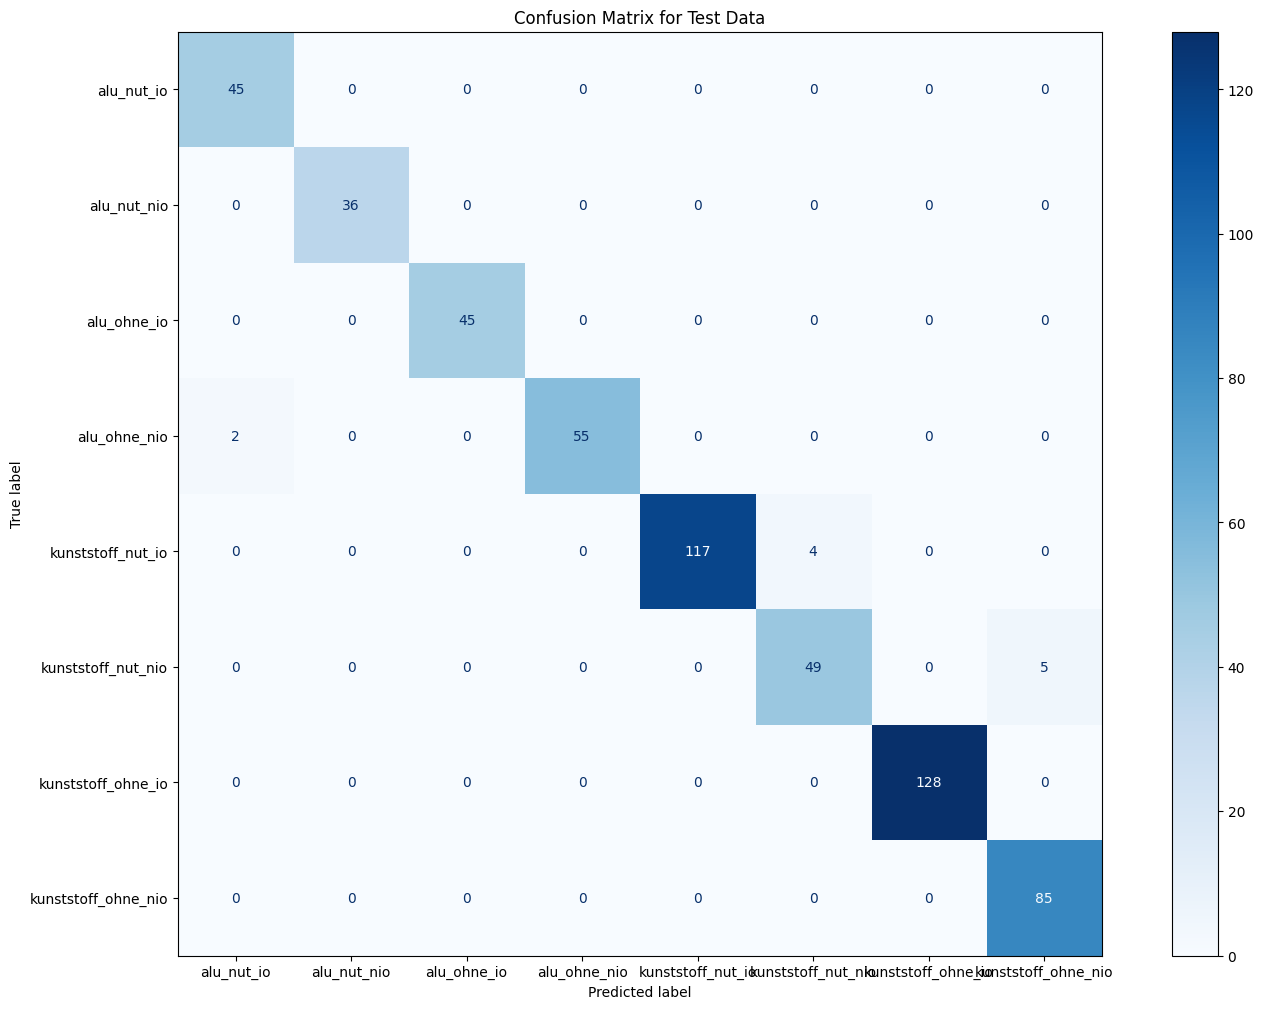

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

test_dir = './spectrograms/test'
model = load_model('pt16-m55013.h5')
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False
)

def evaluate_and_plot(generator, title):
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    unique_true_classes = np.unique(true_classes)
    class_labels = [list(generator.class_indices.keys())[i] for i in unique_true_classes]
    
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    fig, ax = plt.subplots(figsize=(18, 12))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(title)
    plt.show()

evaluate_and_plot(test_generator, 'Confusion Matrix for Test Data')


In [7]:
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np


test_dir = './spectrograms/test'
model = load_model('pt16-m55013.h5')

datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False
)

predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Found 571 images belonging to 8 classes.
18/18 [==============================] - 5s 265ms/step
                     precision    recall  f1-score   support

         alu_nut_io       0.96      1.00      0.98        45
        alu_nut_nio       1.00      1.00      1.00        36
        alu_ohne_io       1.00      1.00      1.00        45
       alu_ohne_nio       1.00      0.96      0.98        57
  kunststoff_nut_io       1.00      0.97      0.98       121
 kunststoff_nut_nio       0.92      0.91      0.92        54
 kunststoff_ohne_io       1.00      1.00      1.00       128
kunststoff_ohne_nio       0.94      1.00      0.97        85

           accuracy                           0.98       571
          macro avg       0.98      0.98      0.98       571
       weighted avg       0.98      0.98      0.98       571

